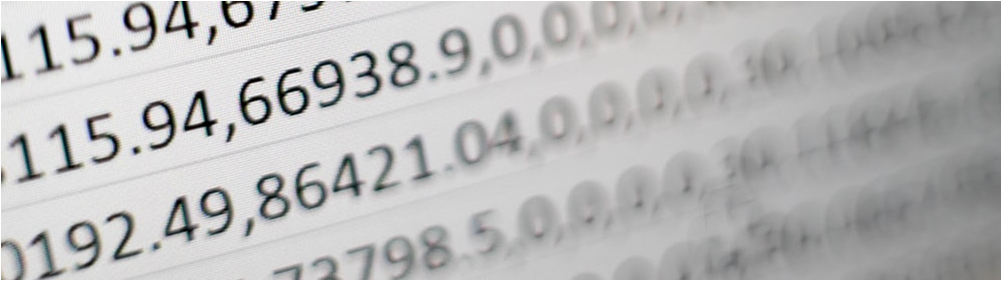

As the competition goes on, GBMs seem to dominate the scene. But I believe that Deep Learning can still play its part in the game. I've already seen some notebook that applied TabNet, but with this notebook I would like to provide you with the basics to create your own deep neural network (DNN) for this problem.

First of all, it is not really easy to create a DNN for tabular data:

* Mixed features data types
* Sparse data which is not the best for DNN
* No SOTA/ best practice architecture
* Less data than in image recognition problems
* There’s suspect from non technical people because DNN are less interpretable than simpler ML algorithms
* Often no best in class solution, because GBM might perform better

But in the end, if you follow these suggestions (some already covered by 30 Days of ML), you will surely succeed:

* It takes some effort, don’t expect an automated process or great results at once
* Don’t re-invent the wheel: use TensorFlow/Keras, Scikit-learn, Pandas for your project
* Process and pipeline input accordingly to its type
* Create a suitable neural architecture keeping into account the number of available examples
* Encode prior knowledge (do feature engineering)
* Test and tune your network using cross validation

Apart from feature engineering (more on this a following tutorial), the most effective action that you can take with your data when building a DNN for a tabular problem is to treat your variables accordinly to their type:

* numeric variables -> clean and standardize
* ordinal data -> transform into multiple variables: ordinal encode + one hot encoding
* categorical data with few levels (low categorical) -> one hot encode
* categorical data with many levels (high categorical) -> use embedding layers

If a categorical variable as many different levels, convert it into numeric labels and use an embedding layer (*Guo, Cheng, and Felix Berkhahn. "Entity embeddings of categorical variables." arXiv preprint arXiv:1604.06737, 2016*).

An embedding layers is just a matrix of weights, converting the input size (a numbered dictionary) to a lower dimensionality output (the embedding size).

It is a weighted linear combination whose weights are optimized to prediction.

The resulting embedding is exportable and reusable for other problems.

How does and embedding layer work? Here is simple example:

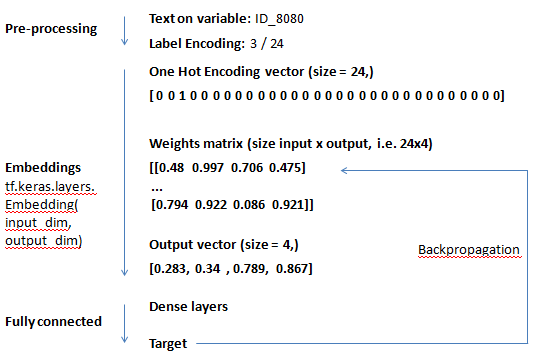

The interesting part of this approach is that you can store away the embeddings and re-use them for other problems of yours if based on the same or similar variabiles (a kind of pre-training). Just have a look at these inspiring examples:

Pinterest: “Applying deep learning to Related Pins” (Pin2vec : https://medium.com/the-graph/applying-deep-learning-to-related-pins-a6fee3c92f5e)

Instacart: “Deep Learning with Emojis (not Math)” (embeddings for grocery items: https://tech.instacart.com/deep-learning-with-emojis-not-math-660ba1ad6cdc)

If you would like a more step-by-step explanation of all the solution in this notebook, just a look at the presentation I gave at the 2019 DevFest in Venice: 

https://www.youtube.com/watch?v=nQgUt_uADSE

and consult the Github repository:

https://github.com/lmassaron/deep_learning_for_tabular_data

I've also tried to comment as much as possible the code, but if you have specific questions, just write to me in the comments!

In [2]:
##### DEEP LEARNING FOR TABULAR DATA  ##########################
# The functions used in this Kernel are based on:
# https://github.com/lmassaron/deep_learning_for_tabular_data
# You can watch the full tutorial presented at the DEVFEST 2019
# explaining how to process tabular data with TensorFlow:
# https://www.youtube.com/watch?v=nQgUt_uADSE
################################################################

!wget https://raw.githubusercontent.com/lmassaron/deep_learning_for_tabular_data/master/tabular.py

--2021-08-25 15:33:31--  https://raw.githubusercontent.com/lmassaron/deep_learning_for_tabular_data/master/tabular.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12625 (12K) [text/plain]
Saving to: ‘tabular.py’

tabular.py          100%[===================>]  12.33K  --.-KB/s    in 0s      

2021-08-25 15:33:31 (70.5 MB/s) - ‘tabular.py’ saved [12625/12625]



In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

# Importing from Scikit-Learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importing TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation, LeakyReLU

# Importing from Tabular
from tabular import gelu, Mish, mish
from tabular import TabularTransformer, DataGenerator

In [4]:
# Registering custom activations suitable for tabular problems

# Add gelu so we can use it as a string
get_custom_objects().update({'gelu': Activation(gelu)})

# Add mish so we can use it as a string
get_custom_objects().update({'mish': Mish(mish)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [9]:
# Loading data 
X = pd.read_csv("../input/30-days-of-ml/train.csv")
X_test = pd.read_csv("../input/30-days-of-ml/test.csv")

In [10]:
# Preparing data as a tabular matrix
y = X.target
X = X.set_index('id').drop('target', axis='columns')
X_test = X_test.set_index('id')

In [11]:
# Stratifying the target
y_stratified = pd.cut(y, bins=10, labels=False)

In [13]:
# Processing categoricals with SVD encoding
categoricals = [item for item in X.columns if 'cat' in item]
X_seq = X[categoricals].apply(lambda x: " ".join(list([str(y) + str(i) for i, y in enumerate(x)])), axis=1)
X_test_seq = X_test[categoricals].apply(lambda x: " ".join(list([str(y) + str(i) for i, y in enumerate(x)])), axis=1)

latent_dims = 24

svd_feats = ['svd_'+str(l) for l in range(latent_dims)]
vectorizer = TfidfVectorizer()

dim_reductio = TruncatedSVD(n_components=24, random_state=0)
X[svd_feats] =  dim_reductio.fit_transform(vectorizer.fit_transform(X_seq))
X_test[svd_feats] = dim_reductio.transform(vectorizer.fit_transform(X_test_seq))

In [14]:
# Dealing with categorical data
categoricals = [item for item in X.columns if 'cat' in item]
ordinal_encoder = OrdinalEncoder()
X[categoricals] = ordinal_encoder.fit_transform(X[categoricals])
X_test[categoricals] = ordinal_encoder.transform(X_test[categoricals])

In [15]:
# Classifying variables so we can use appropriately
numeric_variables = [item for item in X.columns if 'cont' in item] + svd_feats
low_card_categoricals = categoricals[:6]
high_card_categoricals = [categoricals[-1]]
ordinals = categoricals[6:-1]

In [16]:
# Parametric DNN architecture

def tabular_dnn(numeric_variables, categorical_variables=None, categorical_counts=None,
                feature_selection_dropout=0.2, categorical_dropout=0.1,
                first_dense = 256, second_dense = 256, dense_dropout = 0.2, 
                activation_type=gelu):
    
    # Here we pratically deal with everything that is numeric but high cardinality features
    numerical_inputs = Input(shape=(numeric_variables,))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    # Here for each high cardinality feature we build an embedding layer
    if categorical_variables is not None:
        categorical_inputs = []
        categorical_embeddings = []
        for category in  categorical_variables:
            categorical_inputs.append(Input(shape=[1], name=category))
            category_counts = categorical_counts[category]
            categorical_embeddings.append(
                Embedding(category_counts+1, 
                          int(np.log1p(category_counts)+1),  # Heuristic for the embedding dimension
                                                             # feel free to tweak it!
                          name = category + "_embed")(categorical_inputs[-1]))

        if len(categorical_embeddings)==1:
            categorical_logits = Flatten()(SpatialDropout1D(categorical_dropout)(categorical_embeddings[0]))
        else:
            categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                         for cat_emb in categorical_embeddings])
    
        xs = concatenate([numerical_feature_selection, categorical_logits])
    else:
        xs = numerical_feature_selection
        
    x = Dense(first_dense, activation=activation_type)(xs)
    x = Dropout(dense_dropout)(x)  
    x = Dense(second_dense, activation=activation_type)(x)
    x = concatenate([x, xs]) # Skip layer, so we present both the original features 
                             # and the DNN processed ones
    x = Dropout(dense_dropout)(x)
    output = Dense(1)(x)
    
    if categorical_variables is not None:
        model = Model([numerical_inputs] + categorical_inputs, output)
    else:
        model = Model([numerical_inputs], output)
    
    return model


In [17]:
# Useful functions

def RMSE(y_true, y_pred):
    return tf.py_function(partial(mean_squared_error, squared=False), (y_true, y_pred), tf.double)

def MSE(y_true, y_pred):
    return tf.py_function(partial(mean_squared_error, squared=True), (y_true, y_pred), tf.double)

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [18]:
# Global training settings

class Config:
    seed = 0
    folds = 10
    epochs = 50
    batch_size = 1024

In [19]:
# Callbacks

measure_to_monitor = 'val_RMSE' 
modality = 'min'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                               mode=modality, 
                               patience=5, 
                               verbose=0)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor=measure_to_monitor,
                                         mode=modality,
                                         patience=2,
                                         factor=0.5,
                                         verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

In [ ]:
# Setting the CV strategy
skf = StratifiedKFold(n_splits=Config.folds, 
                      shuffle=True, 
                      random_state=Config.seed)

# CV Iteration
score = list()
oof = np.zeros(len(X))
best_iteration = list()
test_preds = np.zeros(len(X_test))

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_stratified)):
    
    tb = TabularTransformer(numeric = numeric_variables,
                            ordinal = ordinals,
                            lowcat  = low_card_categoricals,
                            highcat = high_card_categoricals)

    tb.fit(X.iloc[train_idx])
    sizes = tb.shape(X.iloc[train_idx])
    categorical_levels = dict(zip(high_card_categoricals, sizes[1:]))
    print(f"Input array sizes: {sizes}")
    print(f"Categorical levels: {categorical_levels}\n")
    
    model = tabular_dnn(numeric_variables=sizes[0],
                        categorical_variables=high_card_categoricals,
                        categorical_counts=categorical_levels, 
                        feature_selection_dropout=0.0,
                        categorical_dropout=0.0,
                        first_dense = 128,
                        second_dense = 64,
                        dense_dropout = 0.1,
                        activation_type='relu')
    
    model = compile_model(model, 
                          loss='mean_squared_error', 
                          metrics=[MSE, RMSE], 
                          optimizer=Adam(learning_rate=0.001)
                         )
    
    train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tb,
                                batch_size=Config.batch_size,
                                shuffle=True)
    
    history = model.fit(train_batch,
                        validation_data=(tb.transform(X.iloc[test_idx]), y[test_idx]),
                        epochs=Config.epochs,
                        callbacks=[model_checkpoint, reduce_lr_on_plateau, early_stopping],
                        verbose=1)
    
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['RMSE', 'MSE'])
    
    best_iteration.append(np.argmin(history.history['val_RMSE']) + 1)
    model = load_model('best.model', custom_objects = {"gelu": gelu, "mish": mish, 'MSE': MSE, 'RMSE': RMSE})

    preds = model.predict(tb.transform(X.iloc[test_idx]),
                          verbose=1,
                          batch_size=1024).flatten()

    oof[test_idx] = preds
    score.append(mean_squared_error(y_true=y[test_idx], y_pred=preds, squared=False))
    
    # For each fold we make a prediction
    test_preds += model.predict(tb.transform(X_test[X.columns]),
                                verbose=1,
                                batch_size=1024).flatten()

# Since we cumulated predictions, we divide them by the number of folds 
test_preds /= Config.folds

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Input array sizes: [82, 17]
Categorical levels: {'cat9': 17}

Epoch 1/50
264/264 [==============================] - 23s 81ms/step - loss: 18.3594 - MSE: 18.3382 - RMSE: 3.3255 - val_loss: 1.2891 - val_MSE: 1.2891 - val_RMSE: 1.1245
Epoch 2/50
264/264 [==============================] - 22s 83ms/step - loss: 1.2459 - MSE: 1.2458 - RMSE: 1.1157 - val_loss: 0.6608 - val_MSE: 0.6609 - val_RMSE: 0.8051
Epoch 3/50
202/264 [=====================>........] - ETA: 4s - loss: 1.0952 - MSE: 1.0952 - RMSE: 1.0462

In [ ]:
print("Average RMSE %0.3f ± %0.3f" % (np.mean(score), np.std(score)))
print("RMSE OOF %0.3f" % mean_squared_error(y_true=y, y_pred=oof, squared=False))

In [ ]:
# Predicting and submission
submission = pd.DataFrame({'id':X_test.index, 
                           'target': test_preds.ravel()})

submission.to_csv("submission.csv", index=False)

In [ ]:
submission